### Cell A — Setup & Inspection

In [2]:
# === Cell A — Setup & Inspection ===
from pathlib import Path
import pandas as pd

root = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"
roi_dir  = data_dir / "videos_roi"
fail_csv = root / "runs" / "nslt2000_roi_failures.csv"

man_merged = data_dir / "manifest_nslt2000_merged.csv"
assert man_merged.exists(), f"Missing manifest: {man_merged}"

df_all = pd.read_csv(man_merged)
assert {"video_id","path","gloss","label","split"}.issubset(df_all.columns)

have = sum((roi_dir / f"{str(v).zfill(5)}.mp4").exists() for v in df_all["video_id"])
print("ROI files present on disk:", have, "of", len(df_all))

if fail_csv.exists():
    f = pd.read_csv(fail_csv)
    print("Failures logged so far:", len(f))
    if "reason" in f.columns:
        print(f["reason"].value_counts().head(5))
else:
    print("No failures CSV found.")


ROI files present on disk: 355 of 11980
No failures CSV found.


### Cell B — RESUME ROI (safe, single-process)

In [1]:
# === Cell B — RESUME ROI (stable, single-process, closes MP handles) ===
from pathlib import Path
import os, sys, json, traceback, gc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import cv2
import subprocess

# --- Harden environment (CPU path for mediapipe/tflite, less thread pressure) ---
os.environ.setdefault("MEDIAPIPE_DISABLE_GPU", "1")
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

root     = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"
roi_dir  = data_dir / "videos_roi"
roi_dir.mkdir(parents=True, exist_ok=True)

man_merged = data_dir / "manifest_nslt2000_merged.csv"
df = pd.read_csv(man_merged)
assert {"video_id","path","gloss","label","split"}.issubset(df.columns)

# ----------------- FFmpeg pipe writer helpers -----------------
def open_ffmpeg_writer(out_path, w, h, fps=30, use_nvenc=False, crf_or_cq=23, preset="p4"):
    pix_fmt = "rgb24"
    size_arg = f"{w}x{h}"

    def build_cmd(nvenc):
        if nvenc:
            vcodec = ["-c:v", "h264_nvenc", "-cq", str(crf_or_cq), "-preset", preset]
        else:
            vcodec = ["-c:v", "libx264", "-crf", str(crf_or_cq), "-preset", "medium", "-pix_fmt", "yuv420p"]
        return [
            "ffmpeg", "-y",
            "-f", "rawvideo", "-vcodec", "rawvideo",
            "-pix_fmt", pix_fmt, "-s", size_arg, "-r", str(fps),
            "-i", "-", *vcodec, "-movflags", "+faststart", "-an", str(out_path)
        ]

    for try_nvenc in (False,):  # keep libx264 for max stability
        cmd = build_cmd(try_nvenc)
        proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        return proc, proc.stdin

def write_frame(stdin, frame_bgr):
    rgb = frame_bgr[..., ::-1].copy(order="C")
    stdin.write(rgb.tobytes())

def close_ffmpeg_writer(proc, stdin):
    try:
        if stdin: stdin.flush(); stdin.close()
    except Exception: pass
    try:
        if proc: proc.wait(timeout=10)
    except Exception: pass

# ----------------- MediaPipe & ROI helpers -----------------
def _bbox_from_landmarks(landmarks, w, h):
    if not landmarks: return None
    xs = np.clip([x for x,y in landmarks], 0, w-1)
    ys = np.clip([y for x,y in landmarks], 0, h-1)
    x1, x2 = int(xs.min()), int(xs.max())
    y1, y2 = int(ys.min()), int(ys.max())
    return None if (x2<=x1 or y2<=y1) else [x1,y1,x2,y2]

def _expand_square(b, w, h, margin=0.15):
    x1,y1,x2,y2 = b
    cx, cy = (x1+x2)/2.0, (y1+y2)/2.0
    side = int(max(x2-x1, y2-y1) * (1.0+margin))
    half = side//2
    nx1, ny1 = max(0, int(cx-half)), max(0, int(cy-half))
    nx2, ny2 = min(w, nx1+side), min(h, ny1+side)
    side = min(nx2-nx1, ny2-ny1)
    return [nx1, ny1, nx1+side, ny1+side]

def _sampled_indices(n, k=8):
    if n<=0: return []
    if k>=n: return list(range(n))
    step = n/float(k)
    return [int(i*step) for i in range(k)]

def _fixed_roi_for_clip(frames_bgr, margin=0.15):
    """Create and CLOSE MediaPipe solutions per clip (prevents GL/TFLite leaks)."""
    try:
        import mediapipe as mp
        mp_hands = mp.solutions.hands
        mp_pose  = mp.solutions.pose
        hands = mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=2,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        pose = mp_pose.Pose(
            static_image_mode=False,
            model_complexity=0,
            enable_segmentation=False,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
    except Exception:
        hands = pose = None

    H, W = frames_bgr[0].shape[:2]
    boxes = []
    try:
        for idx in _sampled_indices(len(frames_bgr), k=min(8, len(frames_bgr))):
            f = frames_bgr[idx]
            rgb = cv2.cvtColor(f, cv2.COLOR_BGR2RGB) if hands else None
            lm = []
            if hands:
                rh = hands.process(rgb)
                if rh.multi_hand_landmarks:
                    for hl in rh.multi_hand_landmarks:
                        for p in hl.landmark:
                            lm.append((p.x*W, p.y*H))
            if pose:
                rp = pose.process(rgb)
                if rp.pose_landmarks:
                    for p in rp.pose_landmarks.landmark:
                        y = p.y*H
                        if y < 0.75*H:  # focus upper body
                            lm.append((p.x*W, y))
            if lm:
                b = _bbox_from_landmarks(lm, W, H)
                if b: boxes.append(b)
    finally:
        try:
            if hands: hands.close()
        except Exception:
            pass
        try:
            if pose: pose.close()
        except Exception:
            pass

    if not boxes:
        side = min(W,H); cx=(W-side)//2; cy=(H-side)//2
        return [cx,cy,cx+side,cy+side]
    mean_box = np.array(boxes).mean(axis=0).astype(int).tolist()
    return _expand_square(mean_box, W, H, margin=margin)

def _iter_frames_cv(path, fps_target=30):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened(): 
        return []
    in_fps = cap.get(cv2.CAP_PROP_FPS) or fps_target
    stride = max(1, int(round(in_fps / fps_target)))
    frames = []; i = 0
    while True:
        ok, f = cap.read()
        if not ok: break
        if (i % stride) == 0:
            frames.append(f)
        i += 1
    cap.release()
    return frames

# ----------------- Main resume loop (with checkpointing) -----------------
OUT_SIZE   = 224
FPS_TARGET = 30
CRF_OR_CQ  = 23
CHECKPOINT_EVERY = 200  # write progress periodically

resume_log = root / "runs" / "nslt2000_roi_resume_pass.csv"
rows = []
ok, fail, seen = 0, 0, 0

# Skip those already present
already = sum((roi_dir / f"{str(v).zfill(5)}.mp4").exists() for v in df["video_id"])
print(f"[RESUME] already on disk: {already} | total: {len(df)}")

for _, row in tqdm(df.iterrows(), total=len(df), desc="ROI (stable single-proc)"):
    vid   = int(row["video_id"])
    src   = row["path"]
    gloss = row["gloss"]; label = int(row["label"]); split = row["split"]
    outp  = roi_dir / f"{str(vid).zfill(5)}.mp4"

    if outp.exists():
        rows.append({"video_id":vid,"path":str(outp),"gloss":gloss,"label":label,"split":split,"ok":True,"reason":"exists"})
        ok += 1; seen += 1
        if seen % CHECKPOINT_EVERY == 0:
            pd.DataFrame(rows).to_csv(resume_log, index=False)
        continue

    try:
        frames = _iter_frames_cv(src, fps_target=FPS_TARGET)
        if not frames:
            rows.append({"video_id":vid,"path":str(outp),"gloss":gloss,"label":label,"split":split,"ok":False,"reason":"decode_failed"})
            fail += 1; seen += 1
            if seen % CHECKPOINT_EVERY == 0:
                pd.DataFrame(rows).to_csv(resume_log, index=False)
            continue

        H, W = frames[0].shape[:2]
        box = _fixed_roi_for_clip(frames, margin=0.15)
        x1,y1,x2,y2 = box

        proc, pipe = open_ffmpeg_writer(outp, OUT_SIZE, OUT_SIZE, fps=FPS_TARGET, use_nvenc=False, crf_or_cq=CRF_OR_CQ)
        for f in frames:
            crop = f[y1:y2, x1:x2]
            if crop.size == 0:
                side = min(W,H); cx=(W-side)//2; cy=(H-side)//2
                crop = f[cy:cy+side, cx:cx+side]
            out = cv2.resize(crop, (OUT_SIZE, OUT_SIZE), interpolation=cv2.INTER_AREA)
            if not out.flags['C_CONTIGUOUS']:
                out = np.ascontiguousarray(out)
            write_frame(pipe, out)
        close_ffmpeg_writer(proc, pipe)

        rows.append({"video_id":vid,"path":str(outp),"gloss":gloss,"label":label,"split":split,"ok":True,"reason":"ok"})
        ok += 1; seen += 1
    except Exception as e:
        rows.append({"video_id":vid,"path":str(outp),"gloss":gloss,"label":label,"split":split,"ok":False,"reason":f"err:{e}"})
        fail += 1; seen += 1
    finally:
        # release RAM periodically
        del frames
        gc.collect()

    if seen % CHECKPOINT_EVERY == 0:
        pd.DataFrame(rows).to_csv(resume_log, index=False)

# final flush
pd.DataFrame(rows).to_csv(resume_log, index=False)
print(f"[RESUME DONE] OK: {ok} | FAIL: {fail} | Log -> {resume_log}")


[RESUME] already on disk: 11980 | total: 11980


ROI (stable single-proc):   0%|          | 0/11980 [00:00<?, ?it/s]

[RESUME DONE] OK: 11980 | FAIL: 0 | Log -> /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/runs/nslt2000_roi_resume_pass.csv


### Cell C — Build FINAL ROI Manifest

In [2]:
# === Cell C — Build FINAL ROI manifest ===
from pathlib import Path
import pandas as pd

root = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"
roi_dir  = data_dir / "videos_roi"

df = pd.read_csv(data_dir / "manifest_nslt2000_merged.csv")

def out_path_for(vid):
    return str(roi_dir / f"{str(int(vid)).zfill(5)}.mp4")

df["roi_path"] = df["video_id"].apply(out_path_for)
df_ok = df[df["roi_path"].apply(lambda p: Path(p).exists())].copy()

out_manifest = data_dir / "manifest_nslt2000_roi.csv"
df_ok.rename(columns={"roi_path":"path"})[["video_id","path","gloss","label","split"]].to_csv(out_manifest, index=False)

print(f"[FINAL ROI] {len(df_ok)} clips written -> {out_manifest}")
example = df_ok.iloc[0][["video_id","roi_path","gloss","label","split"]].to_dict()
print("Example:", example)


[FINAL ROI] 11980 clips written -> /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/manifest_nslt2000_roi.csv
Example: {'video_id': 65097, 'roi_path': '/home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/videos_roi/65097.mp4', 'gloss': 'art', 'label': 98, 'split': 'train'}


### Cell D — Quick Visual QA (optional but recommended)

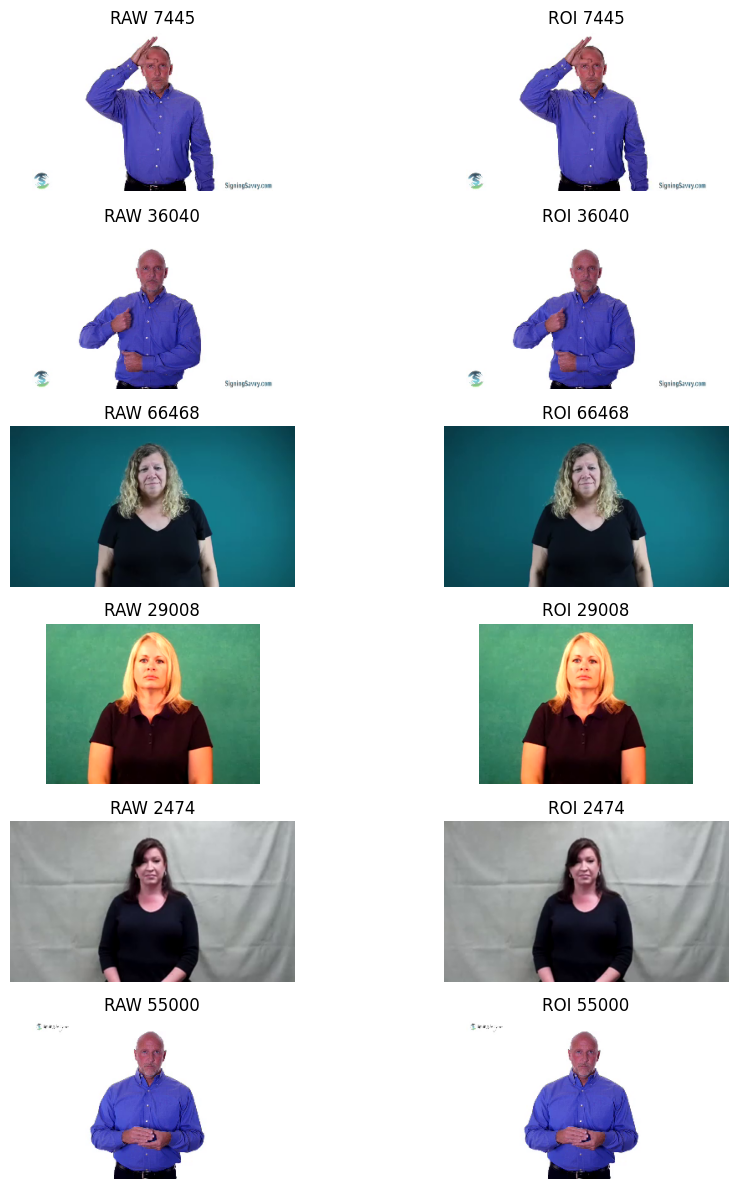

In [3]:
# === Cell D — Visual QA: show a few raw vs ROI crops ===
import random
import numpy as np
import cv2, matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

root = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"
df_raw = pd.read_csv(data_dir / "manifest_nslt2000_merged.csv")
df_roi = pd.read_csv(data_dir / "manifest_nslt2000_roi.csv")

def read_one_frame(p):
    cap = cv2.VideoCapture(p)
    ok, frame = cap.read()
    cap.release()
    return frame if ok else None

S = 6
idxs = random.sample(range(len(df_roi)), k=min(S, len(df_roi)))
plt.figure(figsize=(10, 2*S))
for i, idx in enumerate(idxs, 1):
    row = df_roi.iloc[idx]
    vid = int(row["video_id"])
    p_out = row["path"]
    p_in  = df_raw.loc[df_raw["video_id"]==vid, "path"].values[0]

    f_in  = read_one_frame(p_in)
    f_out = read_one_frame(p_out)

    plt.subplot(S,2,2*i-1); plt.axis("off"); plt.title(f"RAW {vid}")
    if f_in is not None:
        plt.imshow(cv2.cvtColor(f_in, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(np.zeros((224,224,3), dtype=np.uint8))

    plt.subplot(S,2,2*i); plt.axis("off"); plt.title(f"ROI {vid}")
    if f_out is not None:
        plt.imshow(cv2.cvtColor(f_out, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(np.zeros((224,224,3), dtype=np.uint8))

plt.tight_layout(); plt.show()


In [4]:
### We have ran the python scripts to fix and deduplicate the ROI videos. 
# the scripts are: 
# - fix_roi_broken.py
# - roi_dedupe_cleanup.py
#now we  will be building new manifest from disk. 
# the new manifest file will be:  manifest_nslt2000_roi_final.csv 

# === Rebuild manifest_nslt2000_roi_final.csv from disk ===
from pathlib import Path
import re, pandas as pd

root = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"

# Source metadata (keeps gloss/label/split)
merged = pd.read_csv(data_dir / "manifest_nslt2000_merged.csv")

# List what's actually on disk
roi_dir = data_dir / "videos_roi"
files = sorted([p for p in roi_dir.glob("*.mp4")])

def vid_from_name(p):
    m = re.match(r"(\d{5})\.mp4$", p.name)
    return int(m.group(1)) if m else None

roi = pd.DataFrame({
    "video_id": [vid_from_name(p) for p in files],
    "path": [str(p) for p in files],
})
roi = roi.dropna(subset=["video_id"]).astype({"video_id": int})

# Join to pull gloss/label/split from the merged manifest
out = roi.merge(
    merged[["video_id","gloss","label","split"]],
    on="video_id",
    how="left",
    validate="one_to_one"
)

missing_meta = out["gloss"].isna().sum()
print(f"ROI files on disk: {len(roi)} | with metadata: {len(out)} | missing meta rows: {missing_meta}")

# Save final manifest for training
out = out.dropna(subset=["gloss","label","split"]).copy()
out.to_csv(data_dir / "manifest_nslt2000_roi_final.csv", index=False)

sc = {s:int((out['split']==s).sum()) for s in ('train','val','test')}
print(f"[manifest_nslt2000_roi_final.csv] train={sc['train']} val={sc['val']} test={sc['test']} | classes={out['gloss'].nunique()}")
print("Example:", out.iloc[0][['video_id','path','gloss','label','split']].to_dict())


ROI files on disk: 11980 | with metadata: 11980 | missing meta rows: 0
[manifest_nslt2000_roi_final.csv] train=8313 val=2253 test=1414 | classes=2000
Example: {'video_id': 335, 'path': '/home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/videos_roi/00335.mp4', 'gloss': 'abdomen', 'label': 2, 'split': 'test'}


In [5]:
# === Sanity audit for ROI clips ===
import subprocess, json, pandas as pd, numpy as np
from pathlib import Path

root = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"
df = pd.read_csv(data_dir / "manifest_nslt2000_roi_final.csv")

def ffprobe_json(p):
    try:
        out = subprocess.check_output(
            ["ffprobe","-v","error","-print_format","json","-show_streams","-show_format",str(p)],
            stderr=subprocess.STDOUT
        ).decode()
        return json.loads(out)
    except Exception as e:
        return {"error": str(e)}

rows = []
for p in df["path"].unique():
    j = ffprobe_json(p)
    codec = pix = fps = has_audio = None
    ok = False
    if "error" not in j:
        v = [s for s in j["streams"] if s.get("codec_type")=="video"]
        a = [s for s in j["streams"] if s.get("codec_type")=="audio"]
        if v:
            v0 = v[0]
            codec = v0.get("codec_name")
            pix   = v0.get("pix_fmt")
            r = v0.get("avg_frame_rate","0/0")
            try:
                n,d = r.split("/")
                fps = float(n)/float(d) if float(d)!=0 else None
            except: fps=None
            has_audio = 1 if a else 0
            ok = True
    rows.append({"path":p,"probe_ok":ok,"codec":codec,"pix_fmt":pix,"fps":fps,"has_audio":has_audio})

aud = pd.DataFrame(rows)
aud.to_csv(root/"runs"/"nslt2000_audit_roi.csv", index=False)

aud["fps"] = pd.to_numeric(aud["fps"], errors="coerce")
fps_ok = aud["fps"].apply(lambda x: abs(x - 30.0) <= 0.6 if pd.notna(x) else False)

need = (
    (~aud["probe_ok"]) |
    (~aud["codec"].astype(str).str.lower().eq("h264")) |
    (~aud["pix_fmt"].astype(str).str.lower().eq("yuv420p")) |
    (~fps_ok) |
    (pd.to_numeric(aud["has_audio"], errors="coerce").fillna(0).astype(int).eq(1))
)

print("ROI total:", len(aud), "| flagged:", int(need.sum()))
for col,mask in {
    "reason_probe": ~aud["probe_ok"],
    "reason_codec": ~aud["codec"].astype(str).str.lower().eq("h264"),
    "reason_pixfmt": ~aud["pix_fmt"].astype(str).str.lower().eq("yuv420p"),
    "reason_fps": ~fps_ok,
    "reason_audio": pd.to_numeric(aud["has_audio"], errors="coerce").fillna(0).astype(int).eq(1),
}.items():
    print(col, ":", int(mask.sum()))


ROI total: 11980 | flagged: 353
reason_probe : 79
reason_codec : 212
reason_pixfmt : 220
reason_fps : 79
reason_audio : 0
